In [34]:
use_percent = False
use_avg = False
multiple_scenarios = False
smoothing = True
accumulate_max_only = True
smoothing_factor = 2
min_y, max_y = 200, 150

if not use_avg and use_percent:
    print("[warning] percentage graphs cannot be used without average graphs.")

########################### 2023-01-20 ###########################
data_dir = "/home/derposoft/Documents/tb_logs/tb_logs_flairs"
data_lines_baseline_v_gcn_2hp = {
    "baseline_2hp_NOOPT_SEED": "#000000",
    "hybridGCN_2hp_localemb_NOOPT_SEED": "#808080",
}
data_lines_baseline_v_gcn_5hp = {
    "baseline_5hp_NOOPT_SEED": "#000000",
    "hybridGCN_5hp_localemb_NOOPT_SEED": "#808080",
}
data_lines_baseline_v_gcn_20hp = {
    "baseline_20hp_NOOPT_SEED": "#000000",
    "hybridGCN_20hp_localemb_NOOPT_SEED": "#808080",
}

experiments = data_lines_baseline_v_gcn_20hp
scenarios = [
    data_lines_baseline_v_gcn_2hp,
    data_lines_baseline_v_gcn_5hp,
    data_lines_baseline_v_gcn_20hp,
]

########################### 2023-11-19 ###########################
data_dir = "/home/vchad/results_aaai/final/fcscout_210h-10hp-400bs-1em4lr/"
data_dir = "/home/vchad/results_aaai/final/gcnscout_210h-10hp-400bs-1em4lr_GLOBAL/" # bimodal/trimodal example
data_dir = "/home/vchad/results_aaai/_old/baseline_fcscout/"
n_seeds = 10
base_exp = "fcscout_210h-10hp-400bs-1em4lr-eval_NOOPT_SEED"
base_exp = "gcnscout_210h-10hp-400bs-1em4lr-eval_NOOPT_global_SEED" # bimodal/trimodal example
base_exp = "fcscout_200h2.2l_2r2b_OPT-HG-hpr50_SEED"
data_lines_scout_baseline = {
    f"{base_exp}{seed}": "#000000"
    for seed in range(n_seeds)
}
experiments = data_lines_scout_baseline
friendly_names = {
    f"{base_exp}{seed}": f"Baseline, Seed = {seed}"
    for seed in range(n_seeds)
}

In [35]:
import pandas as pd
import numpy as np
import os
ospj = os.path.join
osl = os.listdir

time_column = "num_agent_steps_trained"
data_column = "evaluation/episode_reward_mean"
# friendly_names = {
#     "baseline_2hp_NOOPT_SEED": "Baseline@2HP",
#     "hybridGCN_2hp_localemb_NOOPT_SEED": "GCN@2HP",

#     "baseline_5hp_NOOPT_SEED": "Baseline@5HP",
#     "hybridGCN_5hp_localemb_NOOPT_SEED": "GCN@5HP",
    
#     "baseline_20hp_NOOPT_SEED": "Baseline@20HP",
#     "hybridGCN_20hp_localemb_NOOPT_SEED": "GCN@20HP",
# }
"""
point_at_40k = [
    d[data_column][d.shape[0]-1] for d in data
]
print(dict(zip(labels, point_at_40k)))
for i in range(len(labels)):
    if "baseline" in labels[i]:
        results = []
        for label, point in zip(labels, point_at_40k):
            if "baseline" not in label:
                results.append(f"{label} is {100*(point-point_at_40k[i])/point_at_40k[i]:.4}% ahead of baseline")
        for result in results:
            print(result)
        break
"""
print()

/tmp/ipykernel_2440355/1508732824.py:31: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Aria

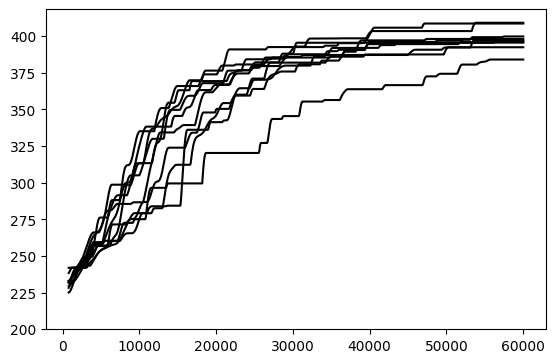

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
import numpy as np

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['lines.marker']  #None
mpl.rcParams['lines.markersize']  #6.0
mpl.rcParams['lines.linewidth']   # 1.5
mpl.rcParams['axes.prop_cycle']

mpl.colors.to_rgb('#1f77b4')

fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.8])

def get_avg_line(data, experiment_filter):
    return np.average(
        [run[data_column].values for run in data[experiment_filter]],
        axis=0,
    )

def use_percent_line(data, baseline):
    data /= baseline
    return data

from scipy.interpolate import make_interp_spline
from scipy.ndimage.filters import gaussian_filter1d
def use_smoothing(data, timesteps):
    _timesteps = np.linspace(timesteps[0], timesteps[-1], len(timesteps)*10)
    spl = make_interp_spline(timesteps, data, k=3)
    _data = spl(_timesteps)
    _data = gaussian_filter1d(_data, sigma=smoothing_factor)
    return _data, _timesteps

def use_accumulated_max_line(data):
    m = 0
    for i in range(len(data)):
        m = max(data[i], m)
        data[i] = m
    return data

def generate_lines_for_scenario(ax, scenario):
    experiments = scenario
    labels = [
        friendly_names[path] for path in experiments
    ]
    experiment_folders = {
        experiment_filter: [x for x in osl(data_dir) if experiment_filter in x]
        for experiment_filter in experiments 
    }
    data = {
        experiment_filter: [
            pd.read_csv(ospj(ospj(data_dir, run_path), "progress.csv"))
            for run_path in experiment_folders[experiment_filter]
        ]
        for experiment_filter in experiment_folders
    }
    lines = []
    handles = []
    for experiment_filter in data:
        baseline_data = get_avg_line(data, list(experiments.keys())[0])
        if use_avg:
            run = data[experiment_filter][0]
            avg_data_line = get_avg_line(data, experiment_filter)
            timesteps = run[[x for x in run.columns if "timestep" in x][0]].values
            if use_percent:
                avg_data_line = use_percent_line(avg_data_line, baseline_data)
            if smoothing:
                avg_data_line, timesteps = use_smoothing(avg_data_line, timesteps)
            lines.append(
                ax.plot(
                    timesteps,
                    avg_data_line,
                    marker='',
                    color=experiments[experiment_filter]
                )
            )
        else:
            for run in data[experiment_filter]:
                timesteps = run[[x for x in run.columns if "timestep" in x][0]].values
                data_line = run[data_column].values
                if smoothing:
                    data_line, timesteps = use_smoothing(data_line, timesteps)
                if accumulate_max_only:
                    data_line = use_accumulated_max_line(data_line)
                lines.append(
                    ax.plot(
                        timesteps,
                        data_line,
                        marker='',
                        color=experiments[experiment_filter]
                    )
                )
        handles.append(lines[-1][0])
    return handles, labels

handles, labels = [], []
if multiple_scenarios:
    for scenario in scenarios:
        _handles, _labels = generate_lines_for_scenario(ax, scenario)
        handles += _handles
        labels += _labels
else:
    handles, labels = generate_lines_for_scenario(ax, experiments)

# ax.legend(
#     handles=handles,
#     labels=labels,
#     loc='upper left',
#     bbox_to_anchor=(1, 1),
#     title='Legend',
#     frameon=False,
# )
#plt.ylim((min_y, max_y))
plt.ylim(bottom=min_y)
plt.show()